# Assignment 1 — Statistical Learning Foundations
Advanced Machine and Deep Learning (WS 25/26)

This notebook contains complete solutions for Q1–Q4. Each section repeats the assignment wording, explains the solution, and provides commented code.

---
## Q1. Estimators — Sample Mean Convergence
**Task:** Generate samples $x_i$ $\sim$ $N(0,1)$ for n $=[10, 100, 1000, 10000, 100000]$ and plot how the sample mean changes as $n$ increases. Include the true mean as a horizontal line.

### Solution Approach
Generate random samples from a standard normal distribution for increasing values of $n$, compute the sample mean for each, and plot the results. The true mean (0) is shown as a reference.

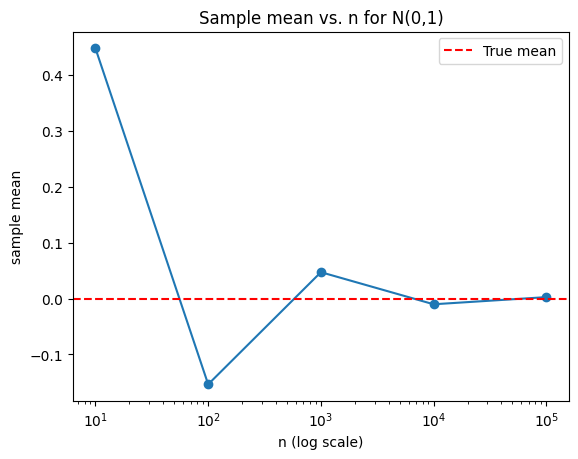

n=    10 -> sample mean = +0.448061
n=   100 -> sample mean = -0.153596
n=  1000 -> sample mean = +0.047197
n= 10000 -> sample mean = -0.010259
n=100000 -> sample mean = +0.002546


In [25]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

ns = [10, 100, 1000, 10000, 100000]
sample_means = []
for n in ns:
    x = np.random.randn(n)
    sample_means.append(np.mean(x))
sample_means = np.array(sample_means)

plt.figure()
plt.plot(ns, sample_means, marker='o')
plt.axhline(0.0, color='r', linestyle='--', label='True mean')
plt.xscale('log')
plt.xlabel('n (log scale)')
plt.ylabel('sample mean')
plt.title('Sample mean vs. n for N(0,1)')
plt.legend()
plt.show()

for n, m in zip(ns, sample_means):
    print(f"n={n:6d} -> sample mean = {m:+.6f}")

---
## Q2. Regression with Gaussian Noise (MLE)
Model: $y_i = x_i^\top \theta + \varepsilon_i$, with $\varepsilon_i \sim \mathcal N(0,\sigma^2)$. For this model,
$$\hat\theta = (X^\top X)^{-1} X^\top y,$$
after standardizing input features (not the target). We:
1. Load CaliforniaHousing (with an offline fallback if needed).
2. Standardize features.
3. Fit the closed-form linear model.
4. Report training and testing MSE.
5. Plot a learning curve (train/test MSE vs. training fraction).
6. Verify the MLE–MSE equivalence by comparing per-sample NLL and MSE using a fixed $\hat\sigma^2$ from the full training residuals.

### Solution Approach
We load the dataset, standardize the input features, and fit a linear regression model using the closed-form solution. We report MSEs, plot a learning curve, and verify the equivalence between MLE and MSE as described.

#### Part a

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.datasets import fetch_california_housing, make_regression

# 1. Load CaliforniaHousing (fallback to synthetic)
def load_california_or_synthetic(random_state: int = 42):
    data = fetch_california_housing()
    X = data.data
    y = data.target
    meta = {"source": "CaliforniaHousing", "feature_names": list(data.feature_names)}
    return X, y, meta

X, y, meta = load_california_or_synthetic()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

# 2. Closed-form solution
import numpy as np
def add_intercept(A):
    return np.hstack([np.ones((A.shape[0], 1)), A])
def closed_form_theta(Xs, y):
    Xb = add_intercept(Xs)
    theta = np.linalg.pinv(Xb.T @ Xb) @ (Xb.T @ y)
    return theta
def predict_theta(theta, Xs):
    return add_intercept(Xs) @ theta
theta_cf = closed_form_theta(Xs_train, y_train)
y_pred_train = predict_theta(theta_cf, Xs_train)
y_pred_test = predict_theta(theta_cf, Xs_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Source: {meta['source']}")
print(f"Training MSE: {mse_train:.6f}")
print(f"Testing  MSE: {mse_test:.6f}")


Source: CaliforniaHousing
Training MSE: 0.517933
Testing  MSE: 0.555892


#### Part b

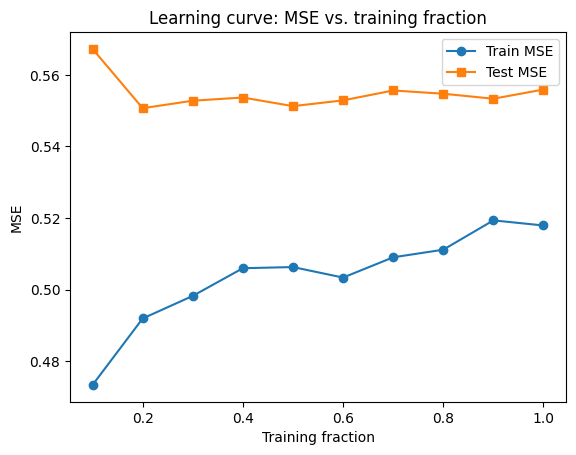

In [32]:

# 3. Learning curve
fractions = np.linspace(0.1, 1.0, 10)
idx = np.random.permutation(len(Xs_train))
mse_tr_curve, mse_te_curve = [], []
for f in fractions:
    k = max(2, int(len(Xs_train) * f))
    X_sub = Xs_train[idx[:k]]
    y_sub = y_train[idx[:k]]
    th = closed_form_theta(X_sub, y_sub)
    mse_tr_curve.append(mean_squared_error(y_sub, predict_theta(th, X_sub)))
    mse_te_curve.append(mean_squared_error(y_test, predict_theta(th, Xs_test)))
plt.figure()
plt.plot(fractions, mse_tr_curve, marker='o', label='Train MSE')
plt.plot(fractions, mse_te_curve, marker='s', label='Test MSE')
plt.xlabel('Training fraction')
plt.ylabel('MSE')
plt.title('Learning curve: MSE vs. training fraction')
plt.legend()
plt.show()


#### Part c

Estimated sigma^2 from full training residuals: 0.517964


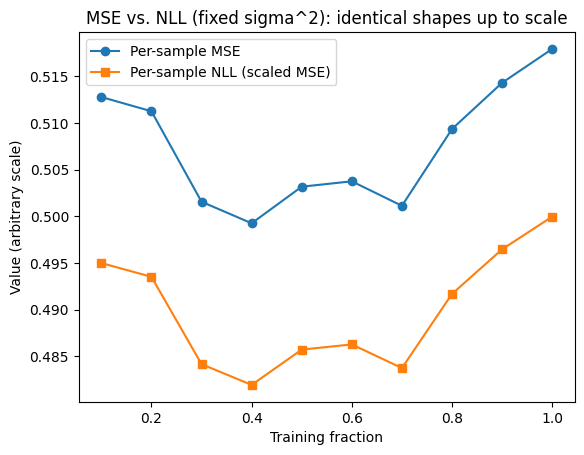

In [31]:

# 4. MLE–MSE equivalence
res_full = y_train - predict_theta(theta_cf, Xs_train)
sigma2_hat = float(np.var(res_full, ddof=1))
print(f"Estimated sigma^2 from full training residuals: {sigma2_hat:.6f}")
per_sample_mse = []
per_sample_nll = []
for f, mse_tr in zip(fractions, mse_tr_curve):
    per_sample_mse.append(mse_tr)
    per_sample_nll.append(0.5 * mse_tr / sigma2_hat)
plt.figure()
plt.plot(fractions, per_sample_mse, marker='o', label='Per-sample MSE')
plt.plot(fractions, per_sample_nll, marker='s', label='Per-sample NLL (scaled MSE)')
plt.xlabel('Training fraction')
plt.ylabel('Value (arbitrary scale)')
plt.title('MSE vs. NLL (fixed sigma^2): identical shapes up to scale')
plt.legend()
plt.show()

---
## Q3. MAP Estimation & Regularization — Ridge vs. Lasso
Under a Gaussian prior $\theta \sim \mathcal N(0, \tau^2 I)$, the MAP solution adds an L2 penalty (Ridge) with $\lambda = \sigma^2/\tau^2$. With a Laplace prior, the MAP solution adds an L1 penalty (Lasso).

**Task:** Standardize inputs, keep target unchanged. For $\lambda \in \{10^{-6},10^{-5},\dots,10^{3}\}$, fit Ridge and Lasso and compute training and testing RMSE for each $\lambda$. Report results and plot RMSE vs. $\log_{10} \lambda$.

### Solution Approach
We fit Ridge and Lasso regression models for a range of $\lambda$ values, compute RMSE for train and test sets, and plot the results as required.

Ridge best test RMSE: 0.7438185949703786 at lambda= 100.0
Lasso best test RMSE: 0.7404423656125414 at lambda= 0.01


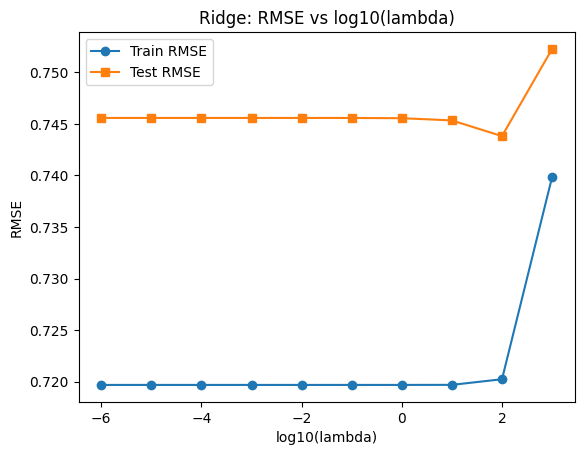

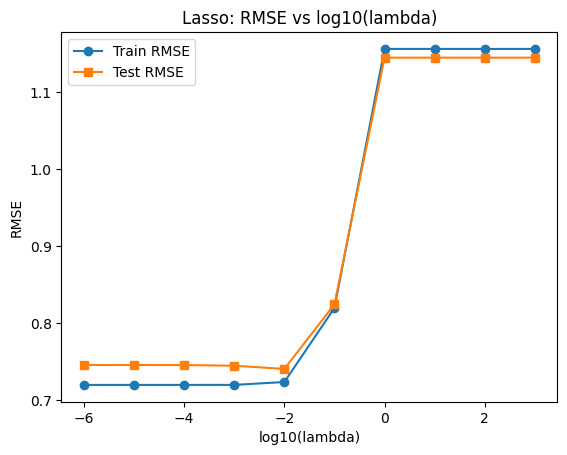

In [33]:
lambdas = np.array([10.0**k for k in range(-6, 4)])  # 1e-6 ... 1e3
ridge_train_rmse, ridge_test_rmse = [], []
lasso_train_rmse, lasso_test_rmse = [], []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(Xs_train, y_train)
    r_tr = np.sqrt(mean_squared_error(y_train, ridge.predict(Xs_train)))
    r_te = np.sqrt(mean_squared_error(y_test, ridge.predict(Xs_test)))
    ridge_train_rmse.append(r_tr)
    ridge_test_rmse.append(r_te)
    lasso = Lasso(alpha=lam, max_iter=20000)
    lasso.fit(Xs_train, y_train)
    l_tr = np.sqrt(mean_squared_error(y_train, lasso.predict(Xs_train)))
    l_te = np.sqrt(mean_squared_error(y_test, lasso.predict(Xs_test)))
    lasso_train_rmse.append(l_tr)
    lasso_test_rmse.append(l_te)
ridge_train_rmse = np.array(ridge_train_rmse)
ridge_test_rmse = np.array(ridge_test_rmse)
lasso_train_rmse = np.array(lasso_train_rmse)
lasso_test_rmse = np.array(lasso_test_rmse)
print("Ridge best test RMSE:", float(ridge_test_rmse.min()), "at lambda=", float(lambdas[ridge_test_rmse.argmin()]))
print("Lasso best test RMSE:", float(lasso_test_rmse.min()), "at lambda=", float(lambdas[lasso_test_rmse.argmin()]))
logl = np.log10(lambdas)
plt.figure()
plt.plot(logl, ridge_train_rmse, marker='o', label='Train RMSE')
plt.plot(logl, ridge_test_rmse, marker='s', label='Test RMSE')
plt.xlabel('log10(lambda)')
plt.ylabel('RMSE')
plt.title('Ridge: RMSE vs log10(lambda)')
plt.legend()
plt.show()
plt.figure()
plt.plot(logl, lasso_train_rmse, marker='o', label='Train RMSE')
plt.plot(logl, lasso_test_rmse, marker='s', label='Test RMSE')
plt.xlabel('log10(lambda)')
plt.ylabel('RMSE')
plt.title('Lasso: RMSE vs log10(lambda)')
plt.legend()
plt.show()

---
## Q4. Information & Cross-Entropy — KL Divergence under Drift
We construct a discrete base distribution $p$ over indices $\{0,1,\dots,20\}$ with a Gaussian shape centered at 10, then create shifted distributions $q_\Delta$ with center moved by $\Delta \in \{-8,-6,\dots,8\}$. We plot:
1. The base $p$.
2. A representative comparison of $p$ vs. $q_\Delta$ (e.g., $\Delta=5$).
3. The KL divergence $D_{\mathrm{KL}}(p\Vert q_\Delta)$ vs. $\Delta$.

All distributions are normalized; we add a small $\varepsilon$ to avoid division by zero in the KL computation.

### Solution Approach
We create the base and shifted distributions, plot them, and compute KL divergence for each drift value as described.

#### Part a) Base Distribution

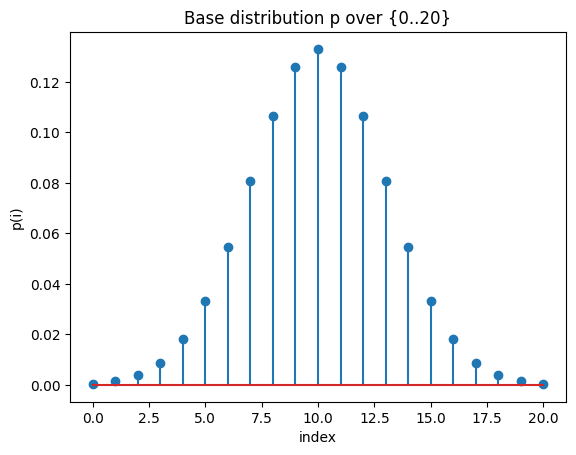

In [34]:
idx = np.arange(21)
center = 10
sigma = 3.0
p = np.exp(-0.5 * ((idx - center)/sigma)**2)
p = p / p.sum()
plt.figure()
plt.stem(idx, p)
plt.xlabel('index')
plt.ylabel('p(i)')
plt.title('Base distribution p over {0..20}')
plt.show()

#### Part b) Shifted Distribution

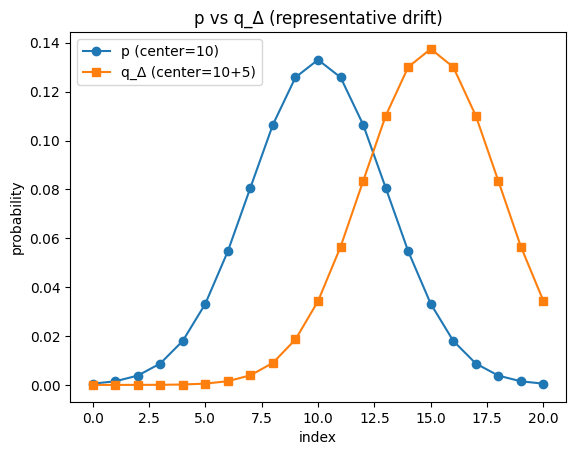

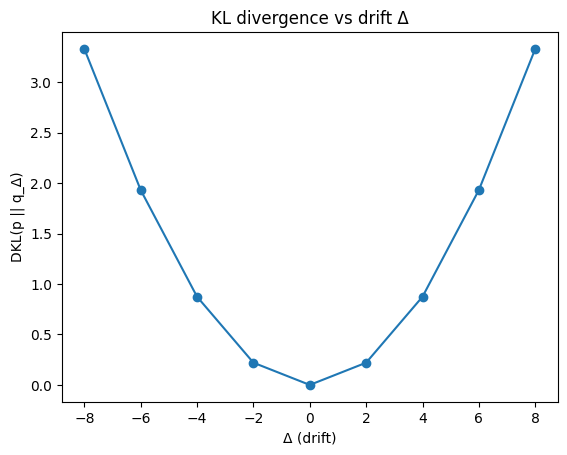

Δ=-8 -> D_KL=3.331308
Δ=-6 -> D_KL=1.932260
Δ=-4 -> D_KL=0.874467
Δ=-2 -> D_KL=0.220433
Δ=+0 -> D_KL=0.000000
Δ=+2 -> D_KL=0.220433
Δ=+4 -> D_KL=0.874467
Δ=+6 -> D_KL=1.932260
Δ=+8 -> D_KL=3.331308


In [35]:

def shifted_q(delta):
    q_center = center + delta
    q = np.exp(-0.5 * ((idx - q_center)/sigma)**2)
    q = q / q.sum()
    return q
delta_example = 5
q_ex = shifted_q(delta_example)
plt.figure()
plt.plot(idx, p, marker='o', label='p (center=10)')
plt.plot(idx, q_ex, marker='s', label=f'q_Δ (center=10+{delta_example})')
plt.xlabel('index')
plt.ylabel('probability')
plt.title('p vs q_Δ (representative drift)')
plt.legend()
plt.show()
def kl_divergence(p, q, eps=1e-12):
    p_safe = np.clip(p, eps, 1.0)
    q_safe = np.clip(q, eps, 1.0)
    return float(np.sum(p_safe * np.log(p_safe / q_safe)))
deltas = np.arange(-8, 9, 2)
kls = []
for d in deltas:
    kls.append(kl_divergence(p, shifted_q(d)))
kls = np.array(kls)
plt.figure()
plt.plot(deltas, kls, marker='o')
plt.xlabel('Δ (drift)')
plt.ylabel('DKL(p || q_Δ)')
plt.title('KL divergence vs drift Δ')
plt.show()
for d, val in zip(deltas, kls):
    print(f"Δ={d:+d} -> D_KL={val:.6f}")